<a href="https://colab.research.google.com/github/amannain122/claim_fraud_detection/blob/main/notebooks/data_exploration_and_handling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import auth
auth.authenticate_user()

In [35]:
from google.cloud import storage
import pandas as pd

# Authenticate and access the GCP bucket
storage_client = storage.Client()
bucket = storage_client.bucket('claims_fraud_data')

# Specify the blob name
blob = bucket.blob('cleaned_claim_data.csv')

# Download the file to a local path (Colab environment)
blob.download_to_filename('/content/cleaned_claim_data.csv')

# Load the CSV data into pandas
df = pd.read_csv('/content/cleaned_claim_data.csv')

df.head()

,Upper_Age,Lower_Age,Reco_Policy_Premium,City_Code,Accomodation_Type,Reco_Insurance_Type,Is_Spouse,Health_Indicator,Holding_Policy_Duration,Holding_Policy_Type,class
0,52.0,52.0,16200.0,C2,Owned,Individual,No,X4,6.0,4.0,0.0
1,67.0,67.0,16900.0,C17,Rented,Individual,No,X1,7.0,3.0,1.0
2,75.0,75.0,25668.0,C10,Owned,Individual,No,X3,3.0,1.0,0.0
3,60.0,57.0,17586.8,C26,Owned,Joint,Yes,X1,14+,1.0,0.0
4,35.0,35.0,12762.0,C12,Rented,Individual,No,X1,3.0,2.0,0.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from imblearn.over_sampling import SMOTE

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23548 entries, 0 to 23547
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Upper_Age                23548 non-null  float64
 1   Lower_Age                23548 non-null  float64
 2   Reco_Policy_Premium      23548 non-null  float64
 3   City_Code                23548 non-null  object 
 4   Accomodation_Type        23548 non-null  object 
 5   Reco_Insurance_Type      23548 non-null  object 
 6   Is_Spouse                23548 non-null  object 
 7   Health_Indicator         23548 non-null  object 
 8   Holding_Policy_Duration  23548 non-null  object 
 9   Holding_Policy_Type      23548 non-null  float64
 10  class                    23548 non-null  float64
dtypes: float64(5), object(6)
memory usage: 2.0+ MB


In [5]:
categorical_columns = ['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Is_Spouse', 'Health_Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type']
numerical_columns = ['Upper_Age', 'Lower_Age', 'Reco_Policy_Premium', 'Holding_Policy_Type']

## Numerical Analysis

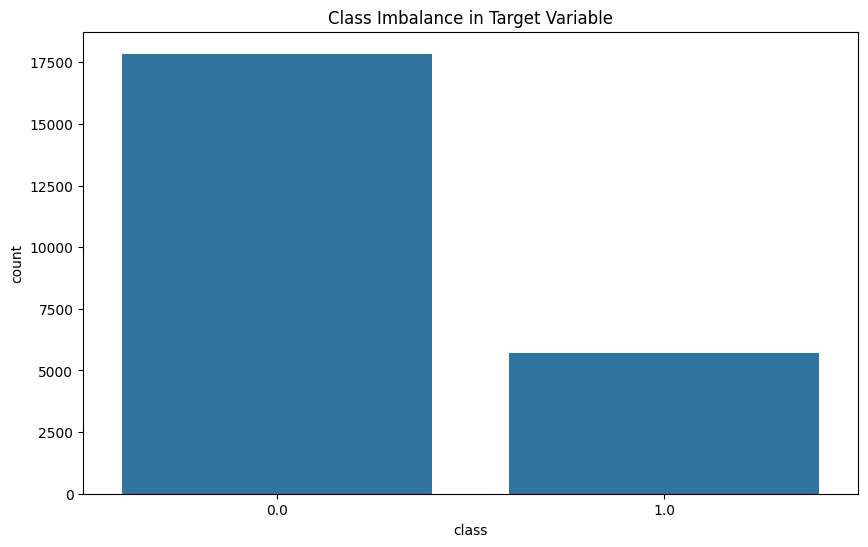

In [6]:
plt.figure(figsize=(10, 6))
sns.countplot(x='class', data=df)
plt.title('Class Imbalance in Target Variable')
plt.show()

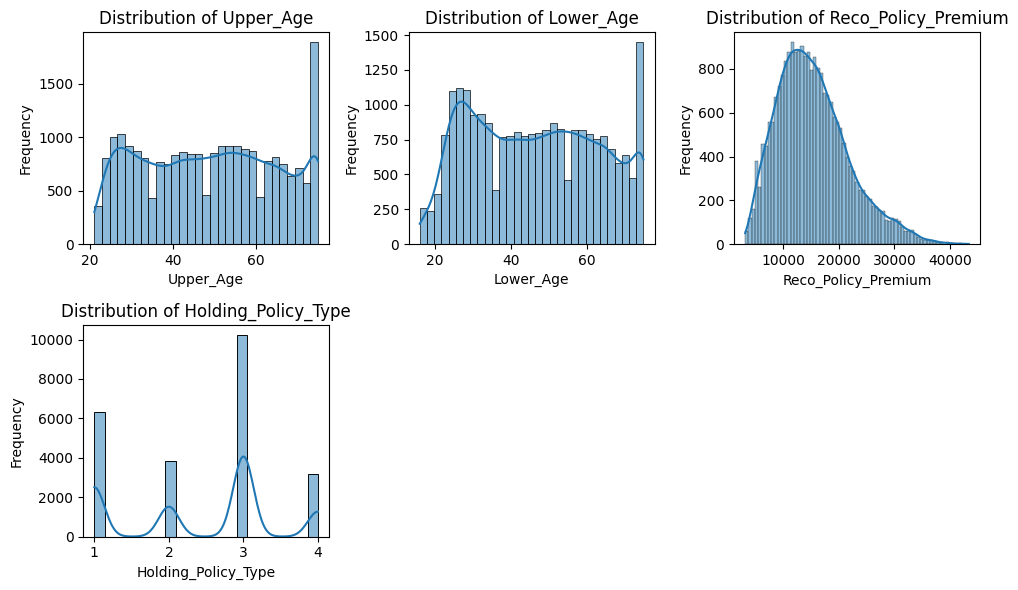

In [7]:
plt.figure(figsize=(10, 6))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

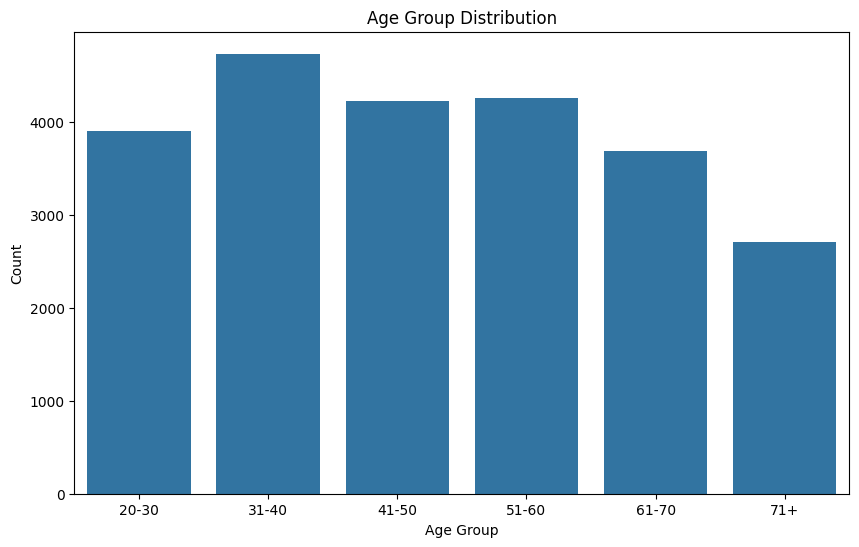

In [8]:
df['average_age'] = (df['Upper_Age'] + df['Lower_Age']) / 2

bins = [20, 30, 40, 50, 60, 70, 80]
labels = ['20-30', '31-40', '41-50', '51-60', '61-70', '71+']

df['age_group'] = pd.cut(df['average_age'], bins=bins, labels=labels, right=False)

df.drop(['Upper_Age', 'Lower_Age', 'average_age'], axis=1, inplace=True)

plt.figure(figsize=(10, 6))
sns.countplot(x='age_group', data=df)
plt.title('Age Group Distribution')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()

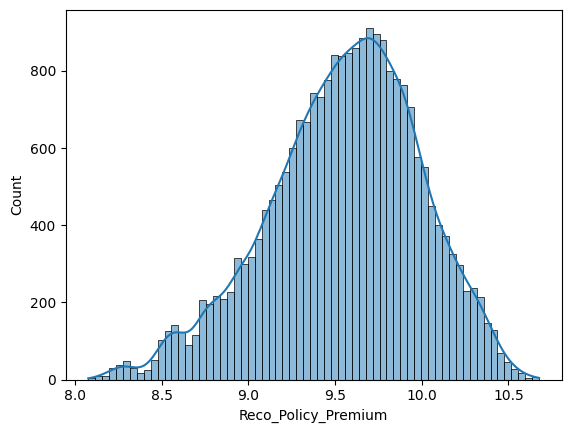

In [9]:
df['Reco_Policy_Premium'] = np.log1p(df['Reco_Policy_Premium'])
sns.histplot(df['Reco_Policy_Premium'], kde=True)
plt.show()

In [33]:
df.head()

,Reco_Policy_Premium,Accomodation_Type,Reco_Insurance_Type,Is_Spouse,Health_Indicator,Holding_Policy_Duration,Holding_Policy_Type,class,age_group,City_Code_C10,...,City_Code_C33,City_Code_C34,City_Code_C35,City_Code_C36,City_Code_C4,City_Code_C5,City_Code_C6,City_Code_C7,City_Code_C8,City_Code_C9
0,0.320879,0,0,0,3,6,4.0,0.0,3,0,...,0,0,0,0,0,0,0,0,0,0
1,0.417791,1,0,0,0,7,3.0,1.0,4,0,...,0,0,0,0,0,0,0,0,0,0
2,1.375256,0,0,0,2,3,1.0,0.0,5,1,...,0,0,0,0,0,0,0,0,0,0
3,0.509051,0,1,1,0,15,1.0,0.0,3,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.225593,1,0,0,0,3,2.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
for col in categorical_columns:
    print(df[col].nunique())

36
2
2
2
9
15
4


## Categorical Analysis

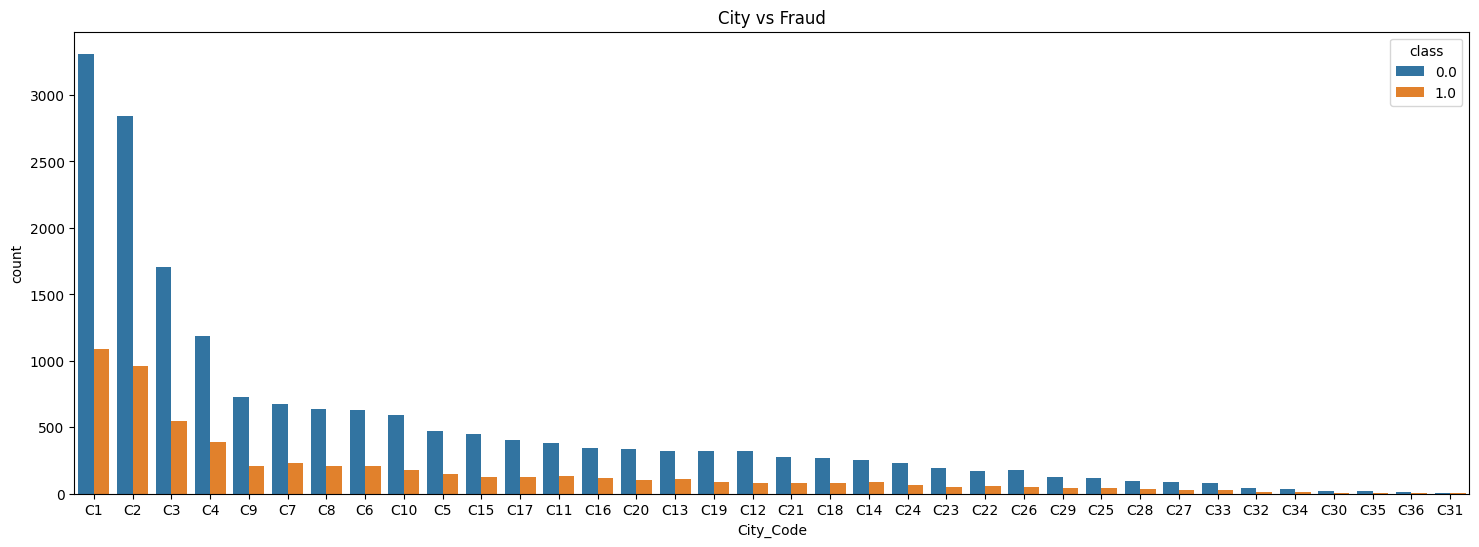

In [12]:
# Plot City vs Fraud
city_order = df['City_Code'].value_counts().index

plt.figure(figsize=(18, 6))
sns.countplot(x='City_Code', hue='class', data=df, order = city_order)
plt.title('City vs Fraud')
plt.show()

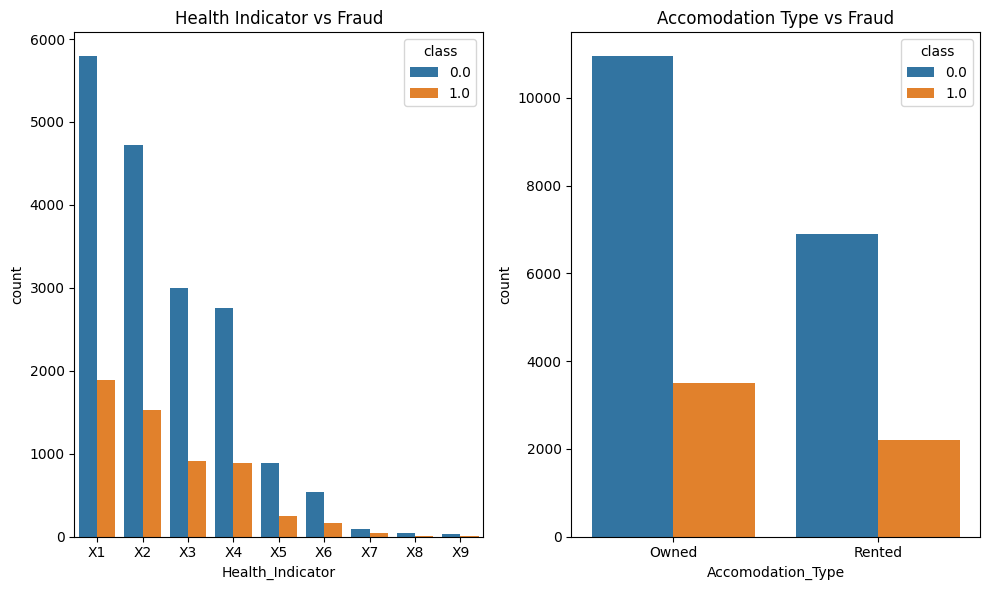

In [13]:
# Plot Health Indicator vs Fraud
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.countplot(x='Health_Indicator', hue='class', data=df, order=df['Health_Indicator'].value_counts().index)
plt.title('Health Indicator vs Fraud')

# Plot Accomodation Type vs Fraud
plt.subplot(1, 2, 2)
sns.countplot(x='Accomodation_Type', hue='class', data=df)
plt.title('Accomodation Type vs Fraud')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

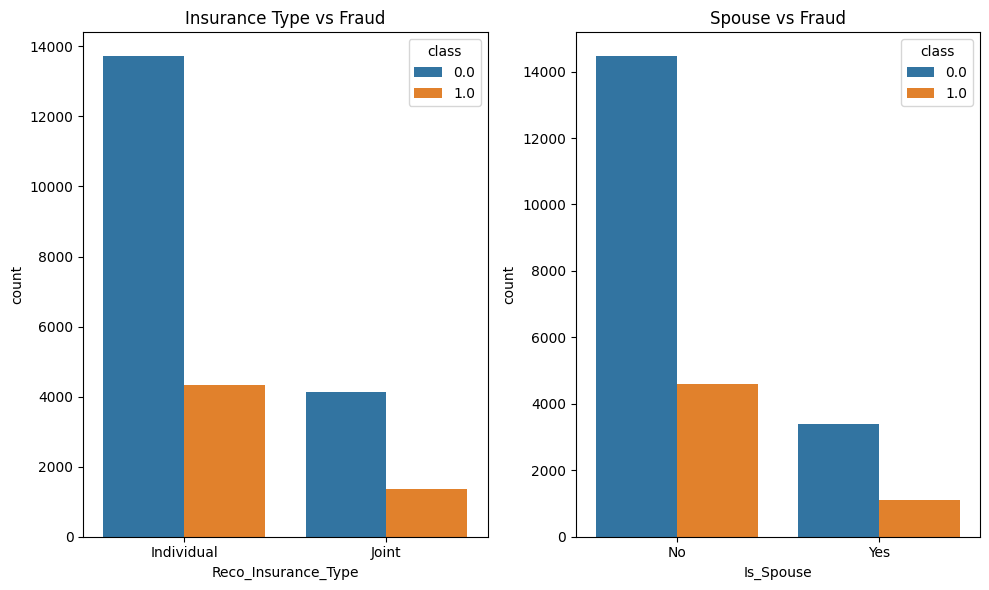

In [14]:
# Plot Health Indicator vs Fraud
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.countplot(x='Reco_Insurance_Type', hue='class', data=df)
plt.title('Insurance Type vs Fraud')

# Plot Accomodation Type vs Fraud
plt.subplot(1, 2, 2)
sns.countplot(x='Is_Spouse', hue='class', data=df)
plt.title('Spouse vs Fraud')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

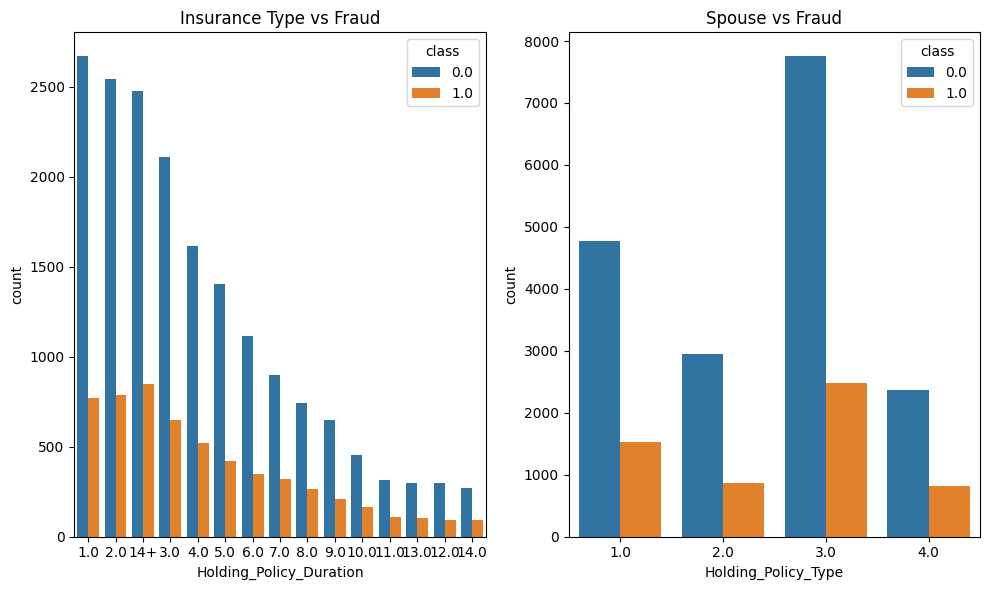

In [15]:
duration_order = df['Holding_Policy_Duration'].value_counts().index

# Plot Health Indicator vs Fraud
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.countplot(x='Holding_Policy_Duration', hue='class', data=df, order = duration_order)
plt.title('Insurance Type vs Fraud')

type_order = ['1.0', '2.0', '3.0', '4.0']
# Plot Accomodation Type vs Fraud
plt.subplot(1, 2, 2)
sns.countplot(x='Holding_Policy_Type', hue='class', data=df, order = type_order)
plt.title('Spouse vs Fraud')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## Encoding

In [16]:
# One-Hot Encoding for City_Code
df = pd.get_dummies(df, columns=['City_Code'], drop_first=True)
for col in df.columns:
    if df[col].dtype == bool:
        df[col] = df[col].astype(int)

# Ordinal Encoding for Holding_Policy_Duration (1.0 to 14+ converted to integer)
df['Holding_Policy_Duration'] = pd.to_numeric(df['Holding_Policy_Duration'].replace({'14+': 15}), errors='coerce').fillna(6).astype(int)

In [17]:
encoder = LabelEncoder()

df['Accomodation_Type'] = encoder.fit_transform(df['Accomodation_Type'])
df['Is_Spouse'] = encoder.fit_transform(df['Is_Spouse'])
df['Reco_Insurance_Type'] = encoder.fit_transform(df['Reco_Insurance_Type'])
df['Health_Indicator'] = encoder.fit_transform(df['Health_Indicator'])
df['age_group'] = encoder.fit_transform(df['age_group'])

In [28]:
df.head()

,Reco_Policy_Premium,Accomodation_Type,Reco_Insurance_Type,Is_Spouse,Health_Indicator,Holding_Policy_Duration,Holding_Policy_Type,class,age_group,City_Code_C10,...,City_Code_C33,City_Code_C34,City_Code_C35,City_Code_C36,City_Code_C4,City_Code_C5,City_Code_C6,City_Code_C7,City_Code_C8,City_Code_C9
0,9.692828,0,0,0,3,6,4.0,0.0,3,0,...,0,0,0,0,0,0,0,0,0,0
1,9.735128,1,0,0,0,7,3.0,1.0,4,0,...,0,0,0,0,0,0,0,0,0,0
2,10.153039,0,0,0,2,3,1.0,0.0,5,1,...,0,0,0,0,0,0,0,0,0,0
3,9.774961,0,1,1,0,15,1.0,0.0,3,0,...,0,0,0,0,0,0,0,0,0,0
4,9.454306,1,0,0,0,3,2.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0


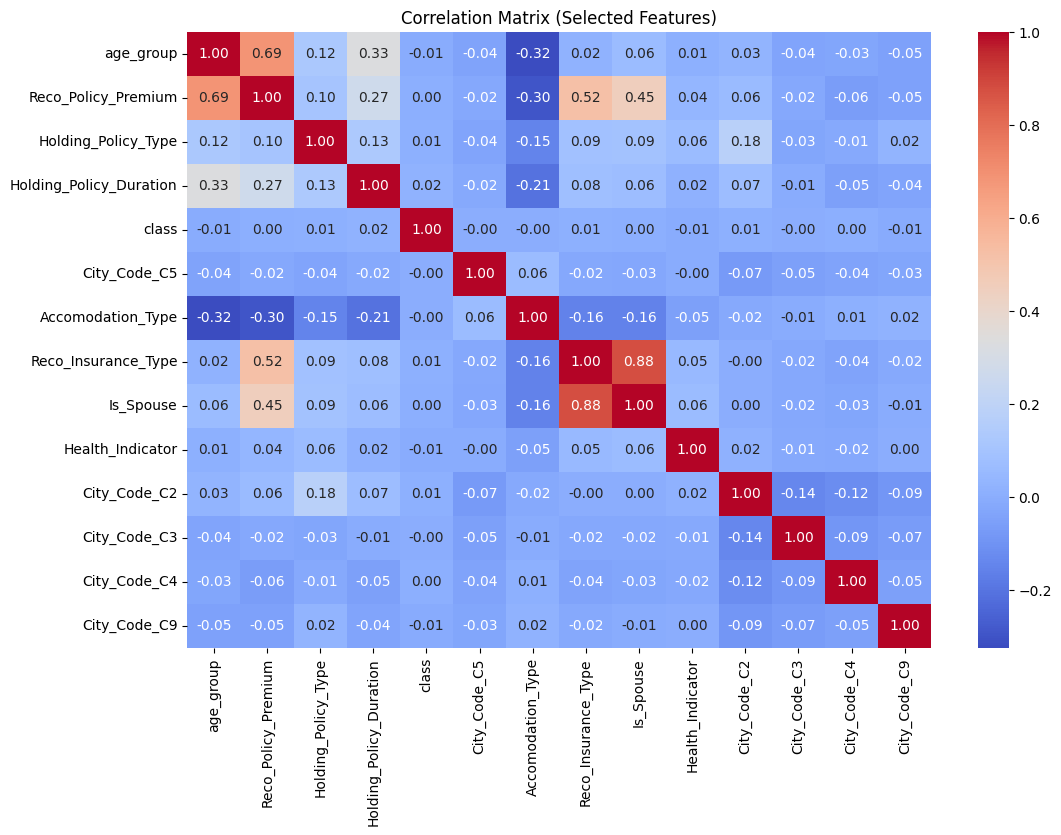

In [27]:
# Manually selected subset of features
selected_columns = [
    'age_group', 'Reco_Policy_Premium', 'Holding_Policy_Type',
    'Holding_Policy_Duration', 'class', 'City_Code_C5', 'Accomodation_Type',
    'Reco_Insurance_Type', 'Is_Spouse', 'Health_Indicator','City_Code_C2','City_Code_C3','City_Code_C4','City_Code_C9'
]

df_corr = df[selected_columns].corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Matrix (Selected Features)')
plt.show()

In [41]:
df.to_csv('encoded_claim_data.csv', index=False)

blob = bucket.blob('encoded_claim_data.csv')
blob.upload_from_filename('encoded_claim_data.csv')